In [ ]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [ ]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [ ]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/BPagano-RtDriven'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [ ]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [ ]:
len(all_data)

77

In [ ]:
df2 = pd.concat(all_data)
df2.head(5)

In [ ]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [ ]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

In [ ]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(75, 7)

In [ ]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [ ]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2022-03-02')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
0,2020-10-24,2020-10-18,1 wk ahead inc case,42,point,NaN,9411.91021,1344.558601
1,2020-10-31,2020-10-25,1 wk ahead inc case,42,point,NaN,12488.21006,1784.030009
2,2020-11-07,2020-11-01,1 wk ahead inc case,42,point,NaN,12774.00000,1824.857143
3,2020-11-14,2020-11-08,1 wk ahead inc case,42,point,NaN,22859.40000,3265.628571
4,2020-11-21,2020-11-15,1 wk ahead inc case,42,point,NaN,43729.40000,6247.057143


In [ ]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[1344.5586014285714, 1344.5586014285714, 1344.5586014285714, 1344.5586014285714, 1344.5586014285714, 1344.5586014285714, 1344.5586014285714, 1784.0300085714284, 1784.0300085714284, 1784.0300085714284, 1784.0300085714284, 1784.0300085714284, 1784.0300085714284, 1784.0300085714284, 1824.857142857143, 1824.857142857143, 1824.857142857143, 1824.857142857143, 1824.857142857143, 1824.857142857143, 1824.857142857143, 3265.628571428572, 3265.628571428572, 3265.628571428572, 3265.628571428572, 3265.628571428572, 3265.628571428572, 3265.628571428572, 6247.057142857143, 6247.057142857143, 6247.057142857143, 6247.057142857143, 6247.057142857143, 6247.057142857143, 6247.057142857143, 9321.028571428571, 9321.028571428571, 9321.028571428571, 9321.028571428571, 9321.028571428571, 9321.028571428571, 9321.028571428571, 8774.266428571429, 8774.266428571429, 8774.266428571429, 8774.266428571429, 8774.266428571429, 8774.266428571429, 8774.266428571429, 10469.1, 10469.1, 10469.1, 10469.1, 10469.1, 10469.1, 

In [ ]:
len(predictions)

495

In [ ]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2020-10-24') & (df1['Date'] <= '2022-03-04')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2020-10-24,3500,3554.6,399204,25603978,882.8,933.0,74512.9,2860489,-5275.682283,2774.207671
1,2020-10-25,3336,3679.2,402540,25603978,716.1,937.8,75229.2,2860489,-5275.682283,2774.207671
2,2020-10-26,4734,3915.1,407274,25603978,1360.9,1031.6,76591.0,2860489,-5275.682283,2774.207671
3,2020-10-27,4556,4133.4,411830,25603978,1153.3,1078.6,77743.5,2860489,-5275.682283,2774.207671
4,2020-10-28,4812,4229.0,416642,25603978,1236.9,1093.9,78980.7,2860489,-5275.682283,2774.207671


In [ ]:
len(df1_copy)

495

In [ ]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [ ]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [ ]:
merged_df_new.shape

(495, 12)

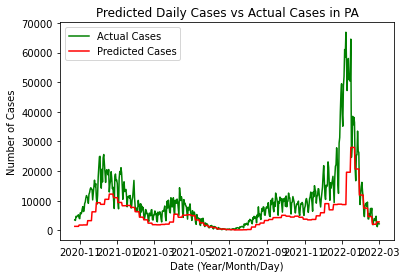

In [ ]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

448
0.9050505050505051
47
0.0949494949494949
495
[0.6158403995918368, 0.5969548556868791, 0.7159783266944294, 0.7048817819515866, 0.7205821692791831, 0.7324793869023933, 0.7442832633266315, 0.5719697676172196, 0.5467403433507549, 0.698031481284457, 0.6772738768864999, 0.696283621285082, 0.7509033777476364, 0.7768288705815076, 0.7126209223847019, 0.7217357208208077, 0.79759792115604, 0.8096728052923297, 0.8331330337548333, 0.8444812388906474, 0.8366287249008825, 0.702149893156825, 0.641297388902837, 0.7311797356413754, 0.7439124395052877, 0.7651978306421793, 0.7729679802955665, 0.7647919496234103, 0.5481006117724868, 0.39148089393559876, 0.49661102797283296, 0.5690495900346895, 0.6308322217907374, 0.5764707021791768, 0.603613125453227, 0.1447028288283565, 0.054653606181101044, 0.20806894040538904, 0.4822226101861698, 0.5697060026115515, 0.6252702190468533, 0.6268304679546572, 0.4684195790275397, 0.3832232230724428, 0.5743127096559563, 0.4624928676444849, 0.6410755776580451, 0.6570944806

In [ ]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.3841596004081632, 0.4030451443131209, 0.2840216733055706, 0.2951182180484134, 0.27941783072081694, 0.26752061309760666, 0.25571673667336847, 0.4280302323827804, 0.45325965664924506, 0.301968518715543, 0.32272612311350013, 0.30371637871491797, 0.24909662225236362, 0.22317112941849238, 0.28737907761529813, 0.2782642791791923, 0.20240207884396, 0.19032719470767034, 0.16686696624516673, 0.1555187611093526, 0.16337127509911753, 0.29785010684317503, 0.35870261109716295, 0.2688202643586246, 0.25608756049471226, 0.23480216935782072, 0.22703201970443354, 0.23520805037658965, 0.4518993882275132, 0.6085191060644013, 0.503388972027167, 0.43095040996531053, 0.3691677782092626, 0.42352929782082316, 0.396386874546773, 0.8552971711716435, 0.945346393818899, 0.791931059594611, 0.5177773898138303, 0.43029399738844853, 0.3747297809531467, 0.37316953204534276, 0.5315804209724603, 0.6167767769275572, 0.42568729034404373, 0.5375071323555152, 0.3589244223419549, 0.3429055193282565, 0.3870430713970635, 0.5

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

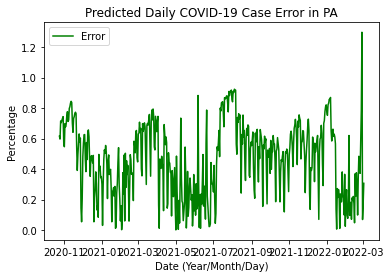

In [ ]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

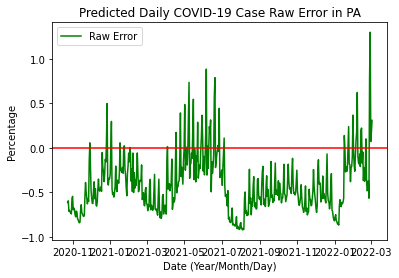

In [ ]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

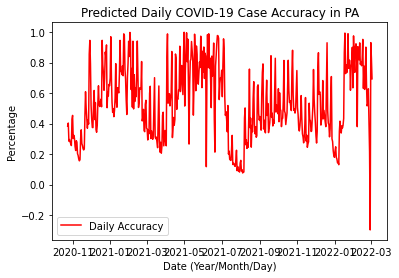

In [ ]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [ ]:
len(weeklyDateList)

71

In [ ]:
del averageWeeklyAccuracy[-1:]
len(averageWeeklyAccuracy)

71

In [ ]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

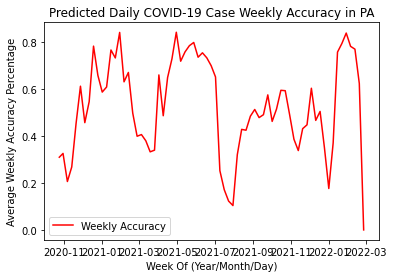

In [ ]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [ ]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

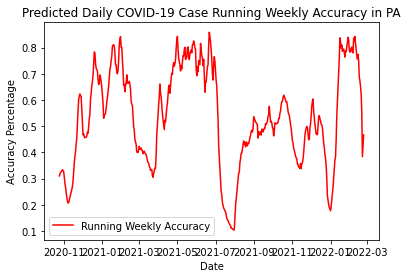

In [ ]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

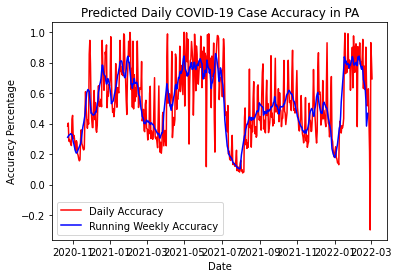

In [ ]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [ ]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [ ]:
del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

17

In [ ]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

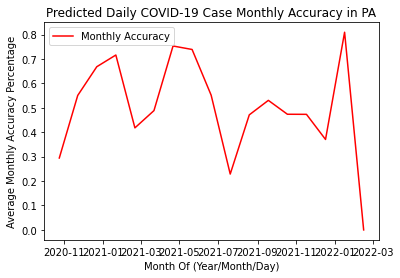

In [ ]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [ ]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

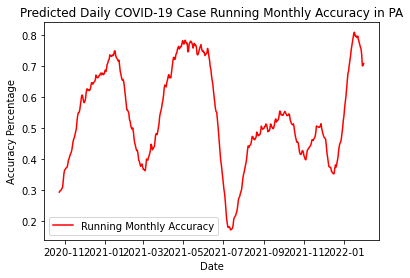

In [ ]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#Calculate Yearly Accuracy Averages
#We are going to use an average of 365 days per year for these calculations

yearlyAccuracy = 0
averageYearlyAccuracy = []
amountOfYears = int(length / 365)
remainderDays = length % 365

i = 0
while i < length:
  yearlyAccuracy += accuracy[i]
  if (i + 1) % 365 == 0 and amountOfYears > 0:
    averageYearlyAccuracy.append(yearlyAccuracy / 365)
    amountOfYears -= 1
    yearlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfYears == 0:
    averageYearlyAccuracy.append(yearlyAccuracy / remainderDays)
    yearlyAccuracy = 0
  i += 1

weeklyDateListForYears = []
i = 0
weeklyDateListForYears.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 365 == 0:
    weeklyDateListForYears.append(merged_df_new['Date'][i])
  i += 1

In [ ]:
print(averageYearlyAccuracy)

[0.5346292806961788, 0.0875447130718305]


In [ ]:
#Create Dataframe for Yearly Accuracy
i = 0
data = []
while i < len(averageYearlyAccuracy):
  data.append([weeklyDateListForYears[i], averageYearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Year Of', 'Average Yearly Accuracy'])

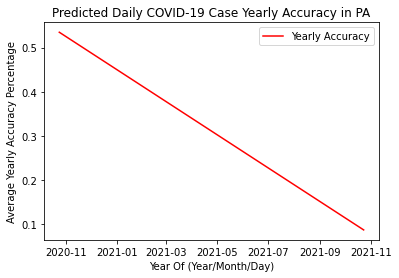

In [ ]:
#Create plot of Yearly Accuracy

#Accuracy Line
plt.plot(df['Year Of'], df['Average Yearly Accuracy'], color='r', label='Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Year Of (Year/Month/Day)') 
plt.ylabel('Average Yearly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#Calculate Running Yearly Accuracy

runningyearlyAccuracy = 0
runningAverageyearlyAccuracy = []
length = len(accuracy)

i = 1
j = 366
#Add first week average
runningAverageyearlyAccuracy.append(averageYearlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningyearlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageyearlyAccuracy.append(runningyearlyAccuracy / 365)
  runningyearlyAccuracy = 0

  i += 1
  j += 1

In [ ]:
#Create Dataframe for Running Yearly Accuracy
i = 0
data = []
while i < len(runningAverageyearlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageyearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Yearly Average Accuracy'])

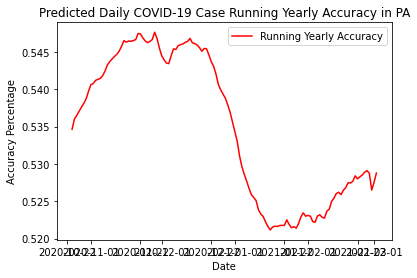

In [ ]:
#Create plot of Running Yearly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Yearly Average Accuracy'], color='r', label='Running Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#Calculate Overall Accuracy
overallAccuracy = merged_df_new['Accuracy'].mean()
print(overallAccuracy)

0.5351311568752738


In [ ]:
#Create new dataframe for year 2022
data_2022 = merged_df_new[(merged_df_new['Date'] > '2022-01-01')]

In [ ]:
#create error and accuracy lists for 2022
error_2022=[]
for index, row in data_2022.iterrows():
  error_2022.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

accuracy_2022 = []
for i in error_2022:
  accuracy_2022.append(1 - i)

In [ ]:
#check head of 2022 data
data_2022.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Prediction,Error,Accuracy,RawError
435,2022-01-02,35128,38695.9,4203914,25603978,6449.2,7426.4,1172327.7,2860489,-5275.682283,2774.207671,8691.9,0.752565,0.247435,-0.752565
436,2022-01-03,48768,41456.9,4252682,25603978,9816.9,8055.2,1182144.5,2860489,-5275.682283,2774.207671,8691.9,0.821770,0.178230,-0.821770
437,2022-01-04,51898,44396.0,4304580,25603978,10744.4,8691.2,1192888.2,2860489,-5275.682283,2774.207671,8691.9,0.832520,0.167480,-0.832520
438,2022-01-05,61004,47411.2,4365584,25603978,11662.5,9215.5,1204551.4,2860489,-5275.682283,2774.207671,8691.9,0.857519,0.142481,-0.857519
439,2022-01-06,58492,49136.1,4424076,25603978,12854.6,9728.8,1217406.1,2860489,-5275.682283,2774.207671,8691.9,0.851400,0.148600,-0.851400


([<matplotlib.axis.XTick at 0x7f3ede5bac50>,
 <a list of 9 Text major ticklabel objects>)

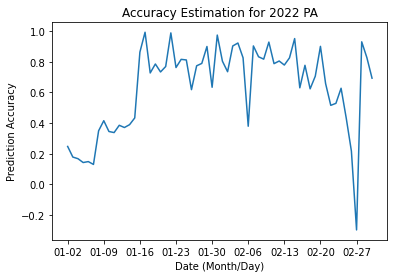

In [ ]:
#create plot for 2022 accuracy
plt.xlabel('Date (Month/Day)') 
plt.ylabel('Prediction Accuracy') 
plt.title("Accuracy Estimation for 2022 PA")

plt.plot(data_2022['Date'].dt.strftime('%m-%d'), accuracy_2022, label='Accuracy 2022')
plt.xticks(np.arange(0, len(data_2022['Date']), 7))

In [ ]:
#cleans accuracy list of all nan values
newlist = [x for x in accuracy if math.isnan(x) == False]
print(newlist)

[0.3841596004081632, 0.4030451443131209, 0.2840216733055706, 0.2951182180484134, 0.27941783072081694, 0.26752061309760666, 0.25571673667336847, 0.4280302323827804, 0.45325965664924506, 0.301968518715543, 0.32272612311350013, 0.30371637871491797, 0.24909662225236362, 0.22317112941849238, 0.28737907761529813, 0.2782642791791923, 0.20240207884396, 0.19032719470767034, 0.16686696624516673, 0.1555187611093526, 0.16337127509911753, 0.29785010684317503, 0.35870261109716295, 0.2688202643586246, 0.25608756049471226, 0.23480216935782072, 0.22703201970443354, 0.23520805037658965, 0.4518993882275132, 0.6085191060644013, 0.503388972027167, 0.43095040996531053, 0.3691677782092626, 0.42352929782082316, 0.396386874546773, 0.8552971711716435, 0.945346393818899, 0.791931059594611, 0.5177773898138303, 0.43029399738844853, 0.3747297809531467, 0.37316953204534276, 0.5315804209724603, 0.6167767769275572, 0.42568729034404373, 0.5375071323555152, 0.3589244223419549, 0.3429055193282565, 0.3870430713970635, 0.5

In [ ]:
#calculate variance and st deviation of accuracy
var = sum((l-overallAccuracy)**2 for l in newlist) / len(newlist)
st_dev = math.sqrt(var)
print(var)
print(st_dev)

0.056360231167352
0.2374030984788362


In [ ]:
#calculate median of accuracy
accMedian = statistics.median(newlist)
print(accMedian)

0.5116362036946536


In [ ]:
#Seperate Running Weekly Average plot into 3 plots for the 3 variants: Original, Delta, Omicron

# Start Date - May 20th 2021
# Delta: May 20th 2021 - December 1st 2021
# Omicron: December 1st 2021 - Present

In [ ]:
type(merged_df_new['Date'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [98]:
merged_df_new.index[merged_df_new['Date']=='2021-05-20'].tolist()

[208]

In [99]:
merged_df_new.index[merged_df_new['Date']=='2021-12-01'].tolist()

[403]

In [100]:
#print(merged_inner)
standardVariantDF = merged_df_new[:208]
deltaVariantDF = merged_df_new[208:403]
omicronVariantDF = merged_df_new[403:]

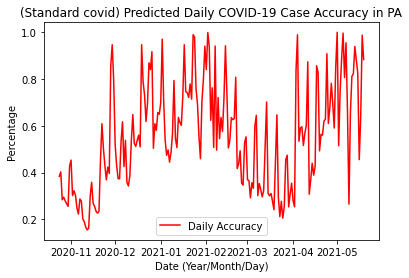

In [101]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(standardVariantDF['Date'], standardVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Standard covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

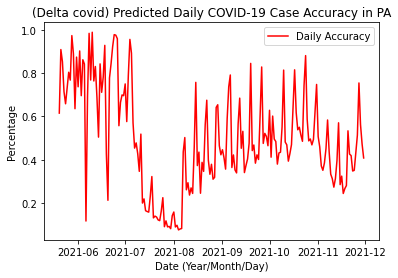

In [102]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(deltaVariantDF['Date'], deltaVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Delta covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

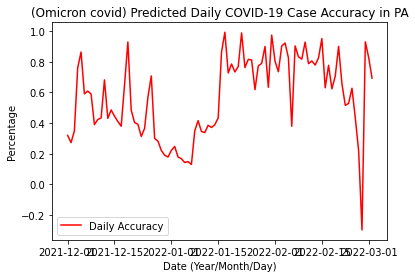

In [103]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(omicronVariantDF['Date'], omicronVariantDF['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("(Omicron covid) Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()